In [10]:
import keras

In [11]:
import os


data_dir='E:/deeplearningtry/'
fname=os.path.join(data_dir,'jena_climate_2009_2016.csv')
f=open(fname)
data=f.read()
f.close()

lines=data.split('\n')
header=lines[0].split(',')
lines=lines[1:]
print(header)
print(len(lines))



['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [12]:
import numpy as np
float_data=np.zeros((len(lines),len(header)-1))
for i,line in enumerate(lines):
    values=[float(x)for x in line.split(',')[1:]]
    float_data[i,:]=values

In [13]:
from matplotlib import pyplot as plt


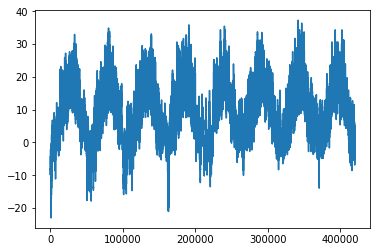

In [14]:
temp=float_data[:,1]
plt.plot(range(len(temp)),temp)
plt.show()

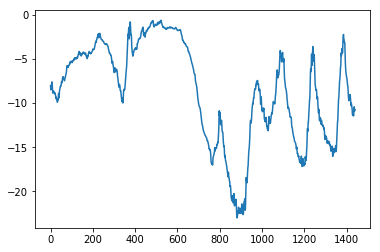

In [15]:
plt.plot(range(1440), temp[:1440])
plt.show()

In [16]:
mean=float_data[:200000].mean(axis=0)
float_data-=mean

In [17]:
std=float_data[:200000].std(axis=0)
float_data/=std

In [18]:
def generator(data,lookback,delay,min_index,max_index,shuffle=False,batch_size=128,step=6):
    if max_index is None:
        max_index=len(data)-delay-1
    i=min_index+lookback
    while True:
        if shuffle:
            rows=np.random.randint(
            min_index+lookback,max_index,size=batch_size)
        else:
            if i+batch_size>=max_index:
                i=min_index+lookback
            rows=np.arange(i,min(i+batch_size,max_index))
            i+=len(rows)
        
        samples=np.zeros((len(rows),lookback//step,data.shape[-1]))
        targets=np.zeros((len(rows),))
        for j,row in enumerate(rows):
            indices=range(rows[j]-lookback,rows[j],step)
            samples[j]=data[indices]
            targets[j]=data[rows[j]+delay][1]
        yield samples,targets
        
            

In [19]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [20]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2897359729905486


In [21]:
from keras.models import Sequential
from keras import layers
from keras.layers import Dense,Flatten
from keras.optimizers import RMSprop

model=Sequential()
model.add(Flatten(input_shape=(lookback//step,float_data.shape[-1])))
model.add(Dense(32,activation='relu'))
model.add(Dense(1))

model.compile(optimizer=RMSprop(),loss='mae')
history=model.fit_generator(train_gen,
                            steps_per_epoch=500,epochs=20,validation_data=val_gen,validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 9s 18ms/step - loss: 1.0984 - val_loss: 0.4474
Epoch 2/20
500/500 [==============================] - 9s 18ms/step - loss: 0.3506 - val_loss: 0.3354
Epoch 3/20
500/500 [==============================] - 9s 17ms/step - loss: 0.2845 - val_loss: 0.3129
Epoch 4/20
500/500 [==============================] - 9s 17ms/step - loss: 0.2638 - val_loss: 0.3004
Epoch 5/20
500/500 [==============================] - 9s 17ms/step - loss: 0.2526 - val_loss: 0.3370
Epoch 6/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2425 - val_loss: 0.3108
Epoch 7/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2357 - val_loss: 0.3061
Epoch 8/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2315 - val_loss: 0.3333
Epoch 9/20
500/500 [==============================] - 9s 17ms/step - loss: 0.2253 - val_loss: 0.3215
Epoch 10/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2214 - val_lo

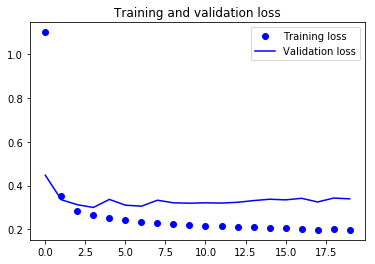

In [23]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [24]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 42s 84ms/step - loss: 0.3033 - val_loss: 0.2825
Epoch 2/20
500/500 [==============================] - 42s 84ms/step - loss: 0.2841 - val_loss: 0.2677
Epoch 3/20
500/500 [==============================] - 43s 86ms/step - loss: 0.2757 - val_loss: 0.2653
Epoch 4/20
500/500 [==============================] - 46s 93ms/step - loss: 0.2701 - val_loss: 0.2689
Epoch 5/20
500/500 [==============================] - 47s 94ms/step - loss: 0.2660 - val_loss: 0.2629
Epoch 6/20
500/500 [==============================] - 45s 90ms/step - loss: 0.2610 - val_loss: 0.2616
Epoch 7/20
500/500 [==============================] - 44s 89ms/step - loss: 0.2569 - val_loss: 0.2631
Epoch 8/20
500/500 [==============================] - 46s 91ms/step - loss: 0.2501 - val_loss: 0.2697
Epoch 9/20
500/500 [==============================] - 45s 91ms/step - loss: 0.2466 - val_loss: 0.2708
Epoch 10/20
500/500 [==============================] - 44s 88ms/step - loss: 0.243

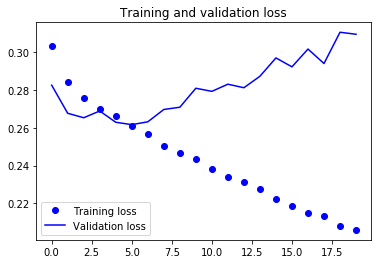

In [26]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Using bidirectional RNNs
The last technique that we will introduce in this section is called "bidirectional RNNs". A bidirectional RNN is common RNN variant which can offer higher performance than a regular RNN on certain tasks. It is frequently used in natural language processing -- you could call it the Swiss army knife of deep learning for NLP.

RNNs are notably order-dependent, or time-dependent: they process the timesteps of their input sequences in order, and shuffling or reversing the timesteps can completely change the representations that the RNN will extract from the sequence. This is precisely the reason why they perform well on problems where order is meaningful, such as our temperature forecasting problem. A bidirectional RNN exploits the order-sensitivity of RNNs: it simply consists of two regular RNNs, such as the GRU or LSTM layers that you are already familiar with, each processing input sequence in one direction (chronologically and antichronologically), then merging their representations. By processing a sequence both way, a bidirectional RNN is able to catch patterns that may have been overlooked by a one-direction RNN.

Remarkably, the fact that the RNN layers in this section have so far processed sequences in chronological order (older timesteps first) may have been an arbitrary decision. At least, it's a decision we made no attempt at questioning so far. Could it be that our RNNs could have performed well enough if it were processing input sequences in antichronological order, for instance (newer timesteps first)? Let's try this in practice and see what we get. All we need to do is write a variant of our data generator, where the input sequences get reverted along the time dimension (replace the last line with yield samples[:, ::-1, :], targets). Training the same one-GRU-layer network as we used in the first experiment in this section, we get the following results:

In [27]:
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

In [28]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen_reverse,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 51s 102ms/step - loss: 0.4770 - val_loss: 0.4835
Epoch 2/20
500/500 [==============================] - 50s 99ms/step - loss: 0.4367 - val_loss: 0.4418
Epoch 3/20
500/500 [==============================] - 50s 99ms/step - loss: 0.3879 - val_loss: 0.4337
Epoch 4/20
500/500 [==============================] - 49s 99ms/step - loss: 0.3568 - val_loss: 0.4234
Epoch 5/20
500/500 [==============================] - 50s 99ms/step - loss: 0.3358 - val_loss: 0.4188
Epoch 6/20
500/500 [==============================] - 49s 99ms/step - loss: 0.3172 - val_loss: 0.4182
Epoch 7/20
500/500 [==============================] - 50s 99ms/step - loss: 0.3039 - val_loss: 0.4195
Epoch 8/20
500/500 [==============================] - 50s 99ms/step - loss: 0.2925 - val_loss: 0.4402
Epoch 9/20
500/500 [==============================] - 49s 99ms/step - loss: 0.2832 - val_loss: 0.4198
Epoch 10/20
500/500 [==============================] - 50s 99ms/step - loss: 0.27

In [29]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words (among top max_features most common words)
maxlen = 500

# Load data
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Reverse sequences
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# Pad sequences
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 55s 3ms/step - loss: 0.4935 - acc: 0.7647 - val_loss: 0.4487 - val_acc: 0.8028
Epoch 2/10
20000/20000 [==============================] - 55s 3ms/step - loss: 0.3141 - acc: 0.8781 - val_loss: 0.3795 - val_acc: 0.8362
Epoch 3/10
20000/20000 [==============================] - 54s 3ms/step - loss: 0.2578 - acc: 0.9063 - val_loss: 0.3440 - val_acc: 0.8568
Epoch 4/10
20000/20000 [==============================] - 54s 3ms/step - loss: 0.2170 - acc: 0.9218 - val_loss: 0.3722 - val_acc: 0.8812
Epoch 5/10
20000/20000 [==============================] - 54s 3ms/step - loss: 0.1983 - acc: 0.9302 - val_loss: 0.3474 - val_acc: 0.8818
Epoch 6/10
20000/20000 [==============================] - 55s 3ms/step - loss: 0.1768 - acc: 0.9397 - val_loss: 0.3668 - val_acc: 0.8782
Epoch 7/10
20000/20000 [==============================] - 56s 3ms/step - loss: 0.1515 - acc: 0.9493 - val_loss: 0.3862 - val_acc:

In [30]:
from keras import backend as K

In [31]:
K.clear_session()

In [32]:
model=Sequential()
model.add(layers.Embedding(max_features,32))
model.add(layers.Bidirectional((layers.LSTM(32))))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])
history=model.fit(x_train,y_train,epochs=10,batch_size=128,validation_split=0.2)



Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 81s 4ms/step - loss: 0.5540 - acc: 0.7203 - val_loss: 0.4448 - val_acc: 0.8114
Epoch 2/10
20000/20000 [==============================] - 84s 4ms/step - loss: 0.3302 - acc: 0.8703 - val_loss: 0.4072 - val_acc: 0.8182
Epoch 3/10
20000/20000 [==============================] - 83s 4ms/step - loss: 0.2804 - acc: 0.8978 - val_loss: 0.4489 - val_acc: 0.8586
Epoch 4/10
20000/20000 [==============================] - 84s 4ms/step - loss: 0.2285 - acc: 0.9172 - val_loss: 0.3021 - val_acc: 0.8806
Epoch 5/10
20000/20000 [==============================] - 85s 4ms/step - loss: 0.2078 - acc: 0.9261 - val_loss: 0.3442 - val_acc: 0.8840
Epoch 6/10
20000/20000 [==============================] - 86s 4ms/step - loss: 0.1821 - acc: 0.9378 - val_loss: 0.3750 - val_acc: 0.8660
Epoch 7/10
20000/20000 [==============================] - 87s 4ms/step - loss: 0.1698 - acc: 0.9430 - val_loss: 0.3687 - val_acc:

In [33]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 69s 138ms/step - loss: 0.2931 - val_loss: 0.2730
Epoch 2/40
500/500 [==============================] - 68s 136ms/step - loss: 0.2739 - val_loss: 0.2737
Epoch 3/40
500/500 [==============================] - 70s 139ms/step - loss: 0.2661 - val_loss: 0.2689
Epoch 4/40
500/500 [==============================] - 69s 138ms/step - loss: 0.2626 - val_loss: 0.2717
Epoch 5/40
500/500 [==============================] - 68s 136ms/step - loss: 0.2549 - val_loss: 0.2722
Epoch 6/40
500/500 [==============================] - 86s 171ms/step - loss: 0.2485 - val_loss: 0.2726
Epoch 7/40
500/500 [==============================] - 158s 316ms/step - loss: 0.2443 - val_loss: 0.2808
Epoch 8/40
500/500 [==============================] - 157s 315ms/step - loss: 0.2388 - val_loss: 0.2800
Epoch 9/40
500/500 [==============================] - 113s 227ms/step - loss: 0.2326 - val_loss: 0.2807
Epoch 10/40
500/500 [==============================] - 66s 132ms/step 